In [1]:
import os
import cv2
import random
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.use("Agg")
%matplotlib inline

import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Flatten)
from tensorflow.keras.layers import (Dense, Lambda, Dropout, Activation)

from tensorflow.keras.layers import (Conv2D, MaxPooling2D)
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelBinarizer
from keras.applications.resnet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Dropout
from tensorflow.keras.applications import ResNet50
from keras.applications import ResNet50
from keras.layers import Input, Flatten, Dense, BatchNormalization
from keras.models import Model



In [2]:

STYLES_CSV_PATH = "/kaggle/input/fashion-product-images-dataset/fashion-dataset/styles.csv"
IMAGES_PATH = "/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/"

styles_df = pd.read_csv(STYLES_CSV_PATH, on_bad_lines='skip')

print(styles_df.shape)
styles_df.head()

(44424, 10)


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [3]:
styles_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44424 entries, 0 to 44423
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  44424 non-null  int64  
 1   gender              44424 non-null  object 
 2   masterCategory      44424 non-null  object 
 3   subCategory         44424 non-null  object 
 4   articleType         44424 non-null  object 
 5   baseColour          44409 non-null  object 
 6   season              44403 non-null  object 
 7   year                44423 non-null  float64
 8   usage               44107 non-null  object 
 9   productDisplayName  44417 non-null  object 
dtypes: float64(1), int64(1), object(8)
memory usage: 3.4+ MB


In [4]:
styles_df.isna().sum()

id                      0
gender                  0
masterCategory          0
subCategory             0
articleType             0
baseColour             15
season                 21
year                    1
usage                 317
productDisplayName      7
dtype: int64

In [5]:
styles_df = styles_df.dropna()

columns_to_drop = ['year', 'productDisplayName', 'masterCategory', 'articleType']
existing_columns = [col for col in columns_to_drop if col in styles_df.columns]

styles_df.drop(columns=existing_columns, inplace=True)

styles_df = styles_df[styles_df['id'].isin([int(i.split('.')[0]) for i in os.listdir(IMAGES_PATH)])]

print(styles_df.head())

      id gender subCategory baseColour  season   usage
0  15970    Men     Topwear  Navy Blue    Fall  Casual
1  39386    Men  Bottomwear       Blue  Summer  Casual
2  59263  Women     Watches     Silver  Winter  Casual
3  21379    Men  Bottomwear      Black    Fall  Casual
4  53759    Men     Topwear       Grey  Summer  Casual


In [6]:
print(styles_df.shape)
styles_df.head()

(44072, 6)


,id,gender,subCategory,baseColour,season,usage
0,15970,Men,Topwear,Navy Blue,Fall,Casual
1,39386,Men,Bottomwear,Blue,Summer,Casual
2,59263,Women,Watches,Silver,Winter,Casual
3,21379,Men,Bottomwear,Black,Fall,Casual
4,53759,Men,Topwear,Grey,Summer,Casual


In [7]:

for column in styles_df.columns:
    print(f"Unique values in '{column}':")
    print(styles_df[column].unique())
    print("\n")


Unique values in 'id':
[15970 39386 59263 ... 18842 46694 51623]


Unique values in 'gender':
['Men' 'Women' 'Boys' 'Girls' 'Unisex']


Unique values in 'subCategory':
['Topwear' 'Bottomwear' 'Watches' 'Socks' 'Shoes' 'Belts' 'Flip Flops'
 'Bags' 'Innerwear' 'Sandal' 'Shoe Accessories' 'Fragrance' 'Jewellery'
 'Lips' 'Saree' 'Eyewear' 'Scarves' 'Dress' 'Loungewear and Nightwear'
 'Wallets' 'Apparel Set' 'Headwear' 'Mufflers' 'Skin Care' 'Makeup'
 'Free Gifts' 'Ties' 'Accessories' 'Nails' 'Beauty Accessories'
 'Water Bottle' 'Skin' 'Eyes' 'Bath and Body' 'Gloves'
 'Sports Accessories' 'Cufflinks' 'Sports Equipment' 'Stoles' 'Hair'
 'Perfumes' 'Home Furnishing' 'Umbrellas' 'Wristbands' 'Vouchers']


Unique values in 'baseColour':
['Navy Blue' 'Blue' 'Silver' 'Black' 'Grey' 'Green' 'Purple' 'White'
 'Beige' 'Brown' 'Bronze' 'Teal' 'Copper' 'Pink' 'Off White' 'Maroon'
 'Red' 'Khaki' 'Orange' 'Yellow' 'Charcoal' 'Gold' 'Steel' 'Tan' 'Multi'
 'Magenta' 'Lavender' 'Sea Green' 'Cream' 'Peach' 

Unique values in 'gender':
['Men' 'Women' 'Boys' 'Girls' 'Unisex']




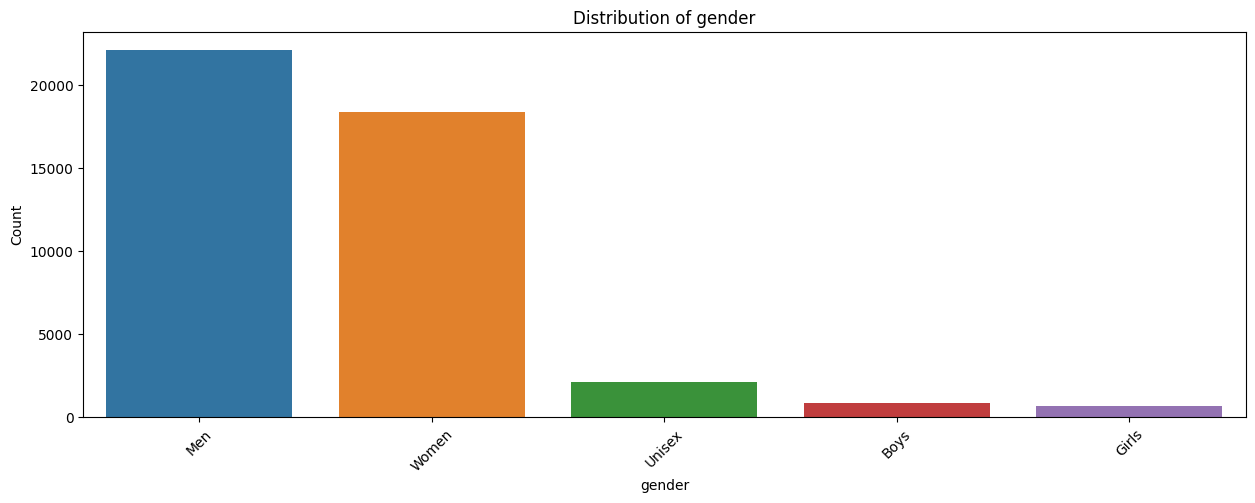

Unique values in 'subCategory':
['Topwear' 'Bottomwear' 'Watches' 'Socks' 'Shoes' 'Belts' 'Flip Flops'
 'Bags' 'Innerwear' 'Sandal' 'Shoe Accessories' 'Fragrance' 'Jewellery'
 'Lips' 'Saree' 'Eyewear' 'Scarves' 'Dress' 'Loungewear and Nightwear'
 'Wallets' 'Apparel Set' 'Headwear' 'Mufflers' 'Skin Care' 'Makeup'
 'Free Gifts' 'Ties' 'Accessories' 'Nails' 'Beauty Accessories'
 'Water Bottle' 'Skin' 'Eyes' 'Bath and Body' 'Gloves'
 'Sports Accessories' 'Cufflinks' 'Sports Equipment' 'Stoles' 'Hair'
 'Perfumes' 'Home Furnishing' 'Umbrellas' 'Wristbands' 'Vouchers']




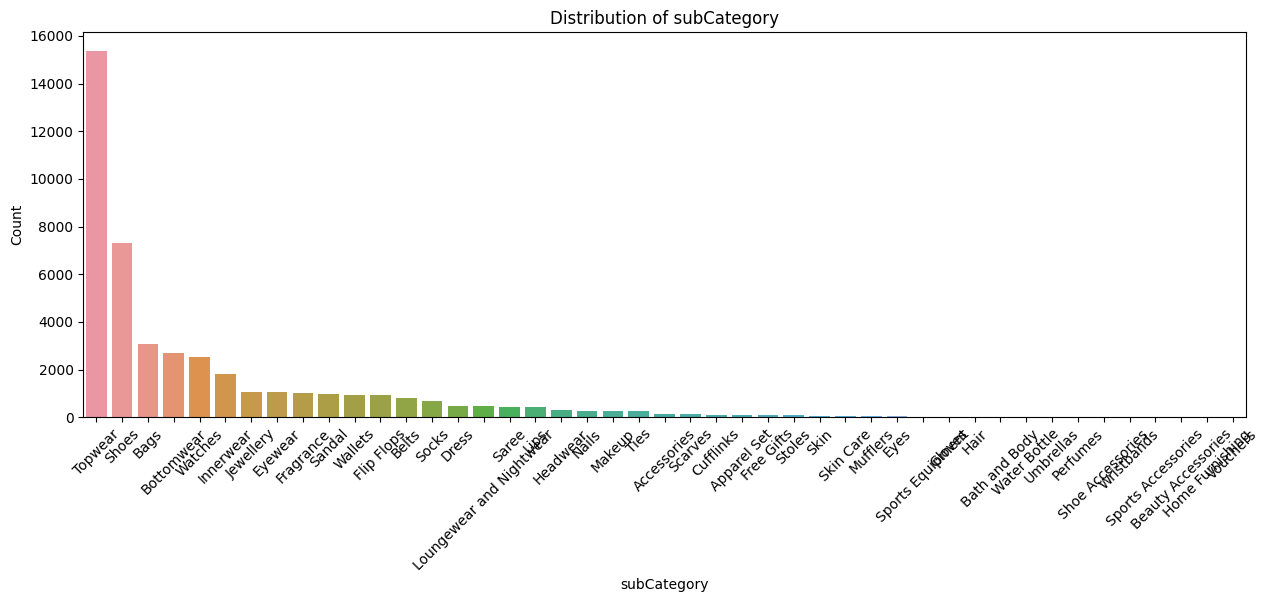

Unique values in 'baseColour':
['Navy Blue' 'Blue' 'Silver' 'Black' 'Grey' 'Green' 'Purple' 'White'
 'Beige' 'Brown' 'Bronze' 'Teal' 'Copper' 'Pink' 'Off White' 'Maroon'
 'Red' 'Khaki' 'Orange' 'Yellow' 'Charcoal' 'Gold' 'Steel' 'Tan' 'Multi'
 'Magenta' 'Lavender' 'Sea Green' 'Cream' 'Peach' 'Olive' 'Skin'
 'Burgundy' 'Coffee Brown' 'Grey Melange' 'Rust' 'Rose' 'Lime Green'
 'Mauve' 'Turquoise Blue' 'Metallic' 'Mustard' 'Taupe' 'Nude'
 'Mushroom Brown' 'Fluorescent Green']




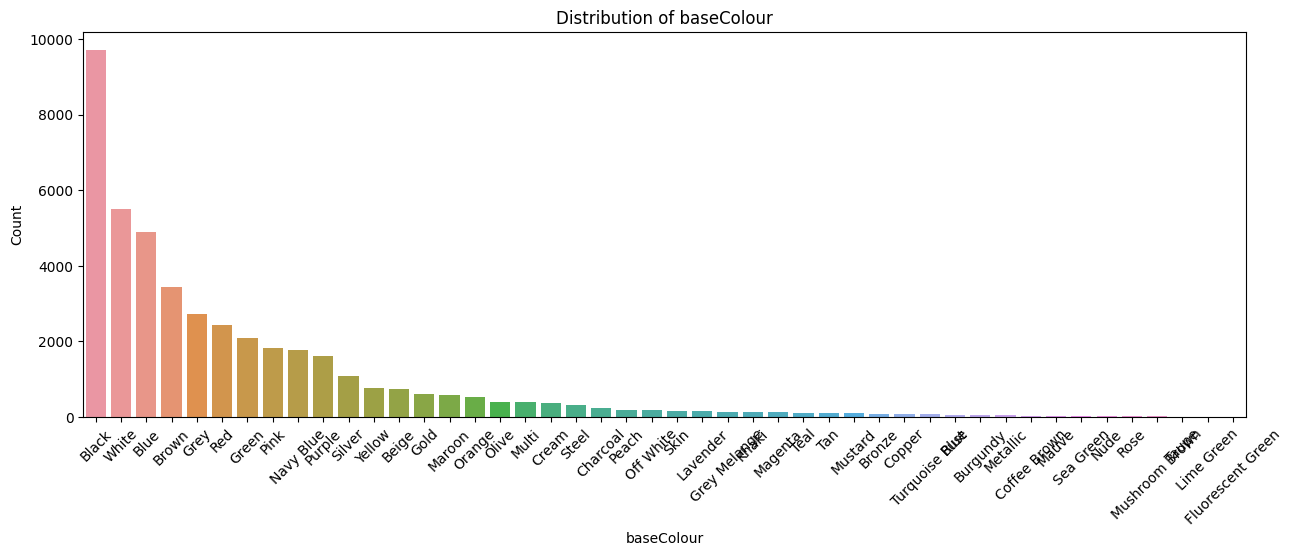

Unique values in 'season':
['Fall' 'Summer' 'Winter' 'Spring']




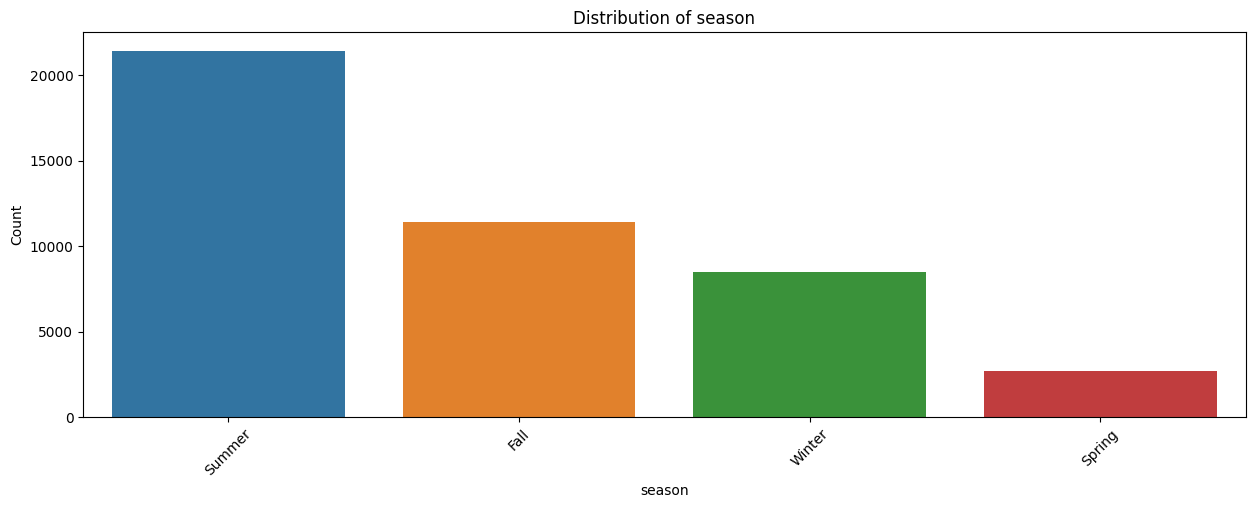

Unique values in 'usage':
['Casual' 'Ethnic' 'Formal' 'Sports' 'Smart Casual' 'Travel' 'Party'
 'Home']




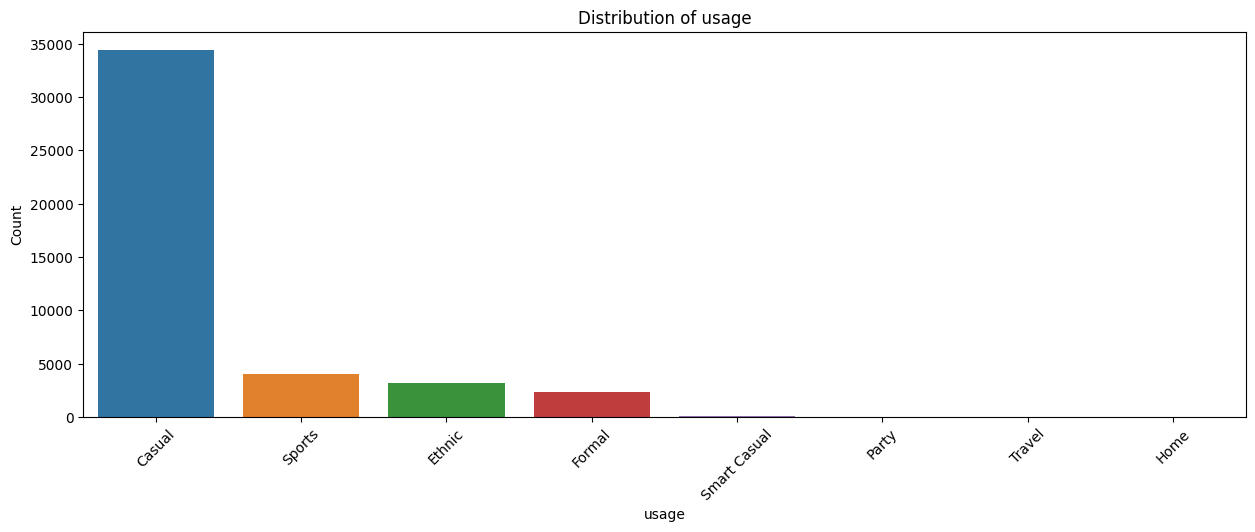

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

for column in styles_df.columns:
    if column == 'id': 
        continue

    print(f"Unique values in '{column}':")
    print(styles_df[column].unique())
    print("\n")
    plt.figure(figsize=(15, 5))
    sns.countplot(data=styles_df, x=column, order=styles_df[column].value_counts().index)
    plt.title(f'Distribution of {column}')
    plt.xticks(rotation=45)  
    plt.ylabel('Count')
    plt.show()


In [9]:
df = styles_df[:15000].copy()

In [10]:
def remove_outliers(data, labels):
    df_labels = pd.DataFrame(labels)

    Q1 = df_labels.quantile(0.25)
    Q3 = df_labels.quantile(0.75)
    IQR = Q3 - Q1

    outlier_condition = ((df_labels < (Q1 - 1.5 * IQR)) | (df_labels > (Q3 + 1.5 * IQR))).any(axis=1)
    
    clean_data = data[~outlier_condition]
    clean_labels = labels[~outlier_condition]

    return clean_data, clean_labels


In [11]:
df['id'] = df['id'].apply(lambda x: IMAGES_PATH+str(x) +'.jpg')
image_ids = df.pop('id')

In [12]:
def bin_values(x):
    x_vc = df[x].value_counts()
    x_other = x_vc[x_vc<50].index
    df.loc[df[x].isin(x_other),x] = 'Other'
    
    
for col in df.columns:
    bin_values(col)

In [13]:

datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [14]:
IMAGE_DIMS = (180, 180, 3)

def load_image(imagePath):
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = preprocess_input(image)
    return image

In [15]:
image_data = []
for img_path in tqdm(image_ids[:13200]):
    image_data.append(load_image(img_path))

100%|██████████| 13200/13200 [05:38<00:00, 39.02it/s]


In [16]:

image_data = np.array(image_data)

print("Image data shape:", image_data.shape)

Image data shape: (13200, 180, 180, 3)


In [17]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelBinarizer

sample_size = 13000

image_data_sampled = image_data[:sample_size]  

subCategoryLB = LabelBinarizer()
genderLB = LabelBinarizer()
baseColourLB = LabelBinarizer()
seasonLB = LabelBinarizer()
usageLB = LabelBinarizer()

subCategoryLabels = subCategoryLB.fit_transform(np.array(df['subCategory'].values[:sample_size])) 
genderLabels = genderLB.fit_transform(np.array(df['gender'].values[:sample_size]))  
baseColourLabels = baseColourLB.fit_transform(np.array(df['baseColour'].values[:sample_size]))  
seasonLabels = seasonLB.fit_transform(np.array(df['season'].values[:sample_size]))  
usageLabels = usageLB.fit_transform(np.array(df['usage'].values[:sample_size]))  

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)


In [18]:

for train_index, test_index in sss.split(image_data_sampled, np.argmax(subCategoryLabels, axis=1)):
    trainX, testX = image_data_sampled[train_index], image_data_sampled[test_index]
    trainSubCategoryY, testSubCategoryY = subCategoryLabels[train_index], subCategoryLabels[test_index]
    trainGenderY, testGenderY = genderLabels[train_index], genderLabels[test_index]
    trainBaseColourY, testBaseColourY = baseColourLabels[train_index], baseColourLabels[test_index]
    trainSeasonY, testSeasonY = seasonLabels[train_index], seasonLabels[test_index]
    trainUsageY, testUsageY = usageLabels[train_index], usageLabels[test_index]


In [19]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelBinarizer

def remove_outliers(data, labels):
    df_labels = pd.DataFrame(labels)

    Q1 = df_labels.quantile(0.25)
    Q3 = df_labels.quantile(0.75)
    IQR = Q3 - Q1
    outlier_condition = ((df_labels < (Q1 - 1.5 * IQR)) | (df_labels > (Q3 + 1.5 * IQR))).any(axis=1)


    clean_indices = np.where(~outlier_condition)[0]
    clean_data = data[clean_indices]
    clean_labels = labels[clean_indices]

    return clean_data, clean_labels, clean_indices

sample_size = 13000  
image_data_sampled = image_data[:sample_size] 

subCategoryLB = LabelBinarizer()
genderLB = LabelBinarizer()
baseColourLB = LabelBinarizer()
seasonLB = LabelBinarizer()
usageLB = LabelBinarizer()

subCategoryLabels = subCategoryLB.fit_transform(np.array(df['subCategory'].values[:sample_size]))  
genderLabels = genderLB.fit_transform(np.array(df['gender'].values[:sample_size]))  
baseColourLabels = baseColourLB.fit_transform(np.array(df['baseColour'].values[:sample_size]))  
seasonLabels = seasonLB.fit_transform(np.array(df['season'].values[:sample_size]))  
usageLabels = usageLB.fit_transform(np.array(df['usage'].values[:sample_size]))  

image_data_clean, subCategoryLabels_clean, clean_indices = remove_outliers(image_data_sampled, subCategoryLabels)

genderLabels_clean = genderLabels[clean_indices]
baseColourLabels_clean = baseColourLabels[clean_indices]
seasonLabels_clean = seasonLabels[clean_indices]
usageLabels_clean = usageLabels[clean_indices]

image_data_clean = image_data_sampled[clean_indices]


In [20]:

trainX, testX, trainSubCategoryY, testSubCategoryY, trainGenderY, testGenderY, trainBaseColourY, testBaseColourY, trainSeasonY, testSeasonY, trainUsageY, testUsageY = train_test_split(
    image_data_clean, subCategoryLabels_clean, genderLabels_clean, baseColourLabels_clean, seasonLabels_clean, usageLabels_clean, test_size=0.2, random_state=42
)


In [21]:

def make_branch(input_layer, num_classes, activation, name):
    """Create a dense branch for classification."""
    x = Dense(512, activation='relu')(input_layer)
    x = Dense(256, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    x = BatchNormalization()(x)

    x = Dense(128, activation='relu')(x)  
    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    x = BatchNormalization()(x)

    x = Dense(128, activation='relu')(x) 
    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu')(x)

    output_layer = Dense(num_classes, activation=activation, name=f'{name}_output')(x)
    return output_layer



In [22]:
def build_model(width, height):
    IMAGE_DIMS = (180, 180, 3)  
    res50 = ResNet50(weights='imagenet', include_top=False, input_shape=IMAGE_DIMS)
    res50.trainable = False 
    inputs = Input(shape=IMAGE_DIMS)

    x = res50(inputs, training=False)  
    x = Flatten()(x)

    subCategory_branch = make_branch(x, len(subCategoryLB.classes_), 'softmax', 'subCategory')
    gender_branch = make_branch(x, len(genderLB.classes_), 'softmax', 'gender')
    color_branch = make_branch(x, len(baseColourLB.classes_), 'softmax', 'color')
    usage_branch = make_branch(x, len(usageLB.classes_), 'softmax', 'usage')
    season_branch = make_branch(x, len(seasonLB.classes_), 'softmax', 'season')  
    
    model = Model(inputs=inputs,
                  outputs=[subCategory_branch, gender_branch, color_branch, usage_branch, season_branch])
    return model


In [23]:
from keras.optimizers import Adam

model = build_model(180, 180)

losses = {
    "subCategory_output": "categorical_crossentropy",
    "gender_output": "categorical_crossentropy",
    "color_output": "categorical_crossentropy",
    "usage_output": "categorical_crossentropy",
    "season_output": "categorical_crossentropy", 
}

metrics = {
    "subCategory_output": "accuracy",
    "gender_output": "accuracy",
    "color_output": "accuracy",
    "usage_output": "accuracy",
    "season_output": "accuracy", 
}


learning_rate = 0.001  

optimizer = Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer, loss=losses, metrics=metrics)

model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 180, 180,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 6, 6,      │ 23,587,712 │ input_layer_1[0]… │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 73728)     │          0 │ resnet50[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │ 37,749,248 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 512)       │ 37,749,248 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 512)       │ 37,749,248 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_27 (Dense)    │ (None, 512)       │ 37,749,248 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_36 (Dense)    │ (None, 512)       │ 37,749,248 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │    131,328 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 256)       │    131,328 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 256)       │    131,328 │ dense_18[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_28 (Dense)    │ (None, 256)       │    131,328 │ dense_27[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_37 (Dense)    │ (None, 256)       │    131,328 │ dense_36[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      8,224 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 32)        │      8,224 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 32)        │      8,224 │ dense_19[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_29 (Dense)    │ (None, 32)        │      8,224 │ dense_28[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_38 (Dense)    │ (None, 32)        │      8,224 │ dense_37[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32)        │        128 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_11[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_20[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_29[0][0]    │
│ (BatchNormalizatio… │                   │            │                 

 Total params: 213,180,671 (813.22 MB)

 Trainable params: 189,592,319 (723.24 MB)

 Non-trainable params: 23,588,352 (89.98 MB)

In [24]:

H = model.fit(
    trainX,
    {
        "subCategory_output": trainSubCategoryY,
        "gender_output": trainGenderY,
        "color_output": trainBaseColourY,
        "usage_output": trainUsageY,
        "season_output": trainSeasonY,
    },
    validation_data=(
        testX,
        {
            "subCategory_output": testSubCategoryY,
            "gender_output": testGenderY,
            "color_output": testBaseColourY,
            "usage_output": testUsageY,
            "season_output": testSeasonY,
        }
    ),
    epochs=40,
    batch_size=32,
    verbose=1
)


Epoch 1/40


I0000 00:00:1738865007.865535     109 service.cc:145] XLA service 0x7b3b540038e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738865007.865630     109 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1738865007.865637     109 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  1/115 ━━━━━━━━━━━━━━━━━━━━ 58:38 31s/step - color_output_accuracy: 0.0312 - gender_output_accuracy: 0.0625 - loss: 11.2746 - season_output_accuracy: 0.0938 - subCategory_output_accuracy: 0.0000e+00 - usage_output_accuracy: 0.1250

I0000 00:00:1738865019.624440     109 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_36', 68 bytes spill stores, 68 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_34', 116 bytes spill stores, 116 bytes spill loads

I0000 00:00:1738865019.644403     109 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - color_output_accuracy: 0.1447 - gender_output_accuracy: 0.7761 - loss: 6.4340 - season_output_accuracy: 0.5960 - subCategory_output_accuracy: 0.8385 - usage_output_accuracy: 0.7195

I0000 00:00:1738865040.561470     110 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_43', 116 bytes spill stores, 116 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_41', 68 bytes spill stores, 68 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_39', 116 bytes spill stores, 116 bytes spill loads



115/115 ━━━━━━━━━━━━━━━━━━━━ 63s 278ms/step - color_output_accuracy: 0.1454 - gender_output_accuracy: 0.7770 - loss: 6.4192 - season_output_accuracy: 0.5966 - subCategory_output_accuracy: 0.8396 - usage_output_accuracy: 0.7203 - val_color_output_accuracy: 0.2894 - val_gender_output_accuracy: 0.9423 - val_loss: 3.8890 - val_season_output_accuracy: 0.6746 - val_subCategory_output_accuracy: 1.0000 - val_usage_output_accuracy: 0.8368
Epoch 2/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 13s 110ms/step - color_output_accuracy: 0.4134 - gender_output_accuracy: 0.9606 - loss: 3.0330 - season_output_accuracy: 0.7802 - subCategory_output_accuracy: 1.0000 - usage_output_accuracy: 0.9013 - val_color_output_accuracy: 0.4004 - val_gender_output_accuracy: 0.9086 - val_loss: 4.2061 - val_season_output_accuracy: 0.4276 - val_subCategory_output_accuracy: 1.0000 - val_usage_output_accuracy: 0.7182
Epoch 3/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - color_output_accuracy: 0.5495 - gender_output_accuracy: 0.9614 -

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


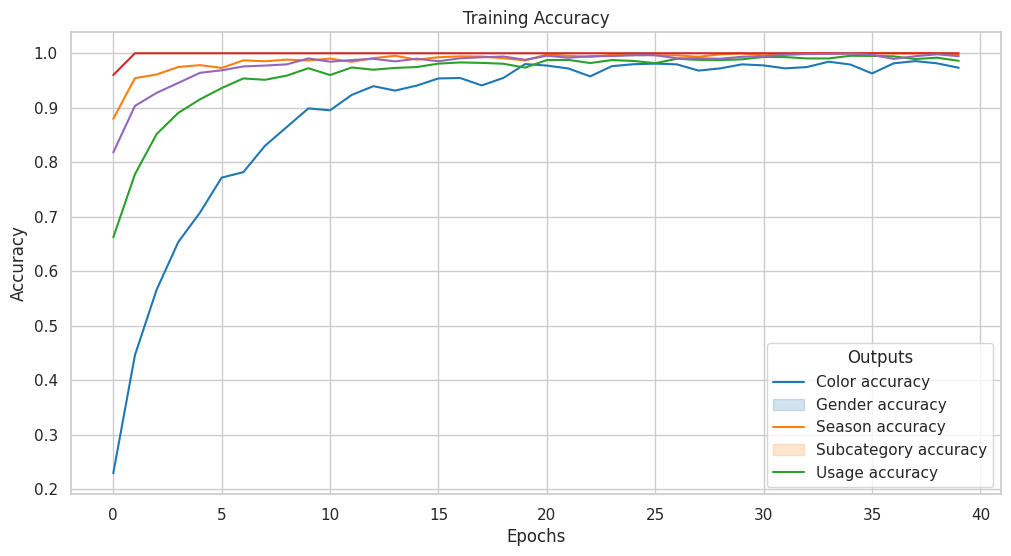

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


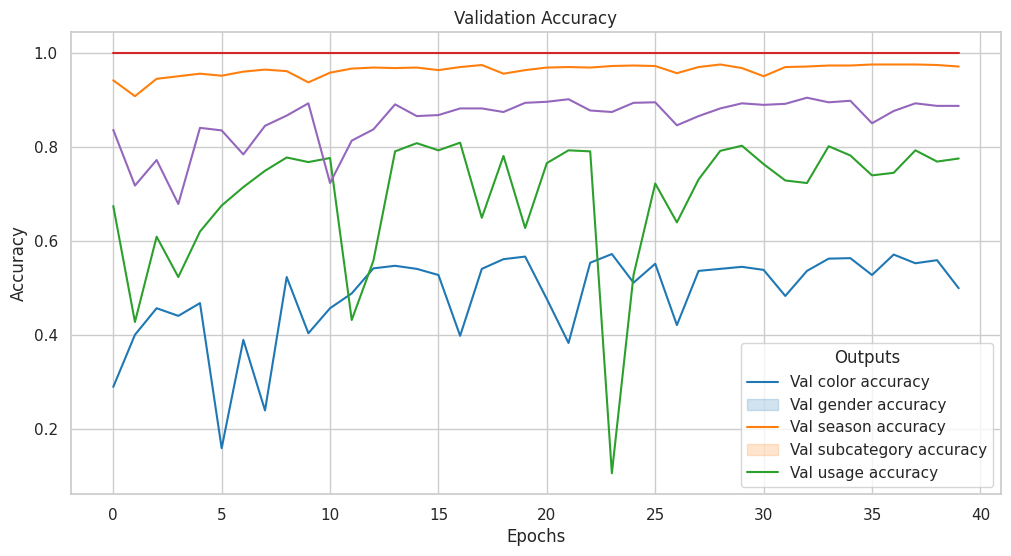

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


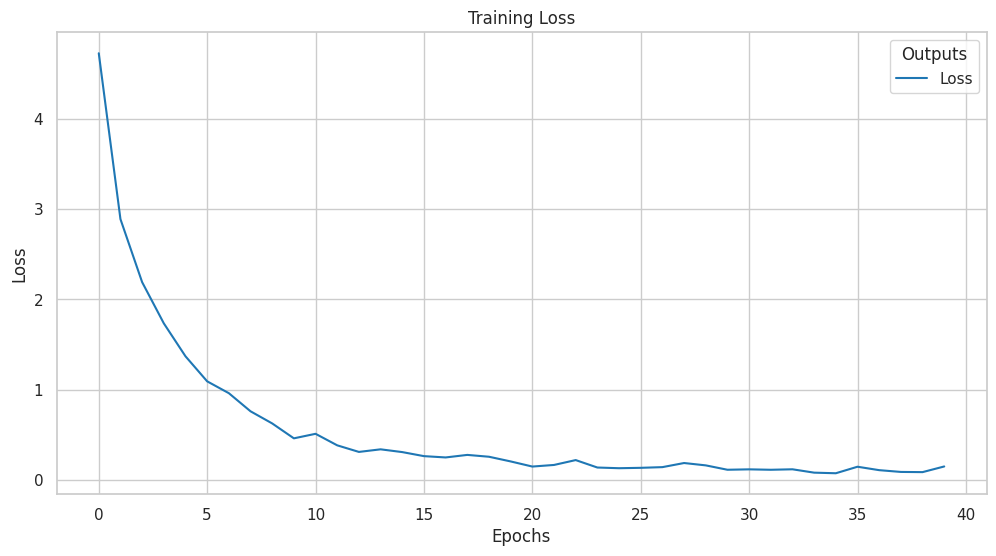

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


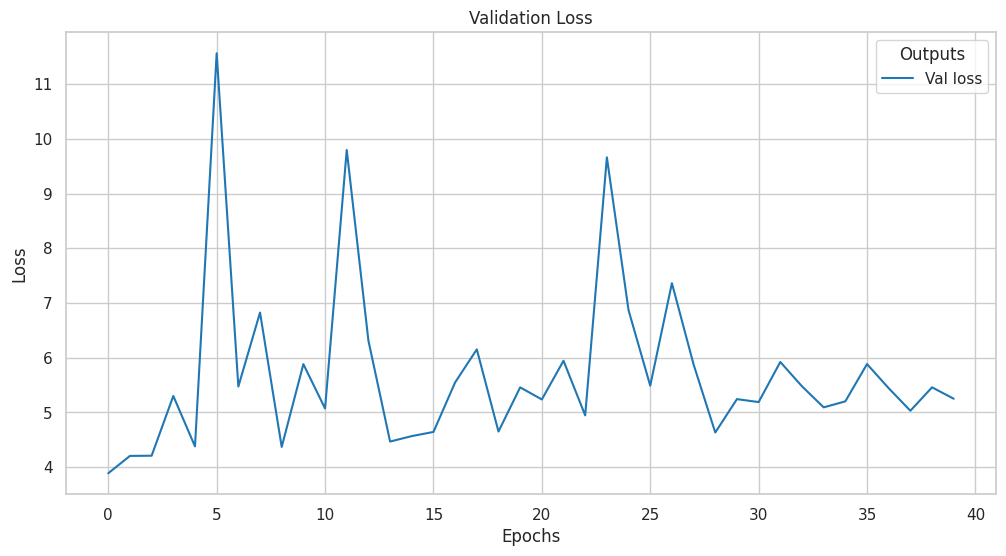

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="whitegrid")

h_df = pd.DataFrame(H.history)

h_df.replace([np.inf, -np.inf], np.nan, inplace=True)

plt.figure(figsize=(12, 6))
sns.lineplot(data=h_df.loc[:, [col for col in h_df.columns if 'accuracy' in col and 'val' not in col]], 
             dashes=False, palette="tab10")
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(title='Outputs', labels=[
    col.replace('_output', '').replace('_', ' ').capitalize() 
    for col in h_df.columns if 'accuracy' in col and 'val' not in col
])
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(data=h_df.loc[:, [col for col in h_df.columns if 'accuracy' in col and 'val' in col]], 
             dashes=False, palette="tab10")
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(title='Outputs', labels=[
    col.replace('_output', '').replace('_', ' ').capitalize() 
    for col in h_df.columns if 'accuracy' in col and 'val' in col
])
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(data=h_df.loc[:, [col for col in h_df.columns if 'loss' in col and 'val' not in col]], 
             dashes=False, palette="tab10")
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(title='Outputs', labels=[
    col.replace('_output', '').replace('_', ' ').capitalize() 
    for col in h_df.columns if 'loss' in col and 'val' not in col
])
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(data=h_df.loc[:, [col for col in h_df.columns if 'loss' in col and 'val' in col]], 
             dashes=False, palette="tab10")
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(title='Outputs', labels=[
    col.replace('_output', '').replace('_', ' ').capitalize() 
    for col in h_df.columns if 'loss' in col and 'val' in col
])
plt.grid(True)
plt.show()


In [26]:

model.save('my_model.h5')

In [27]:
from tensorflow.keras.models import load_model

model = load_model('my_model.h5')


In [34]:
import cv2
import numpy as np
import tensorflow as tf
from keras.applications.resnet import preprocess_input

IMAGE_DIMS = (180, 180, 3)

def load_image(imagePath):
    image = cv2.imread(imagePath)
    if image is None:
        raise ValueError(f"Error: Unable to read image at {imagePath}")
    
    image = cv2.resize(image, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = preprocess_input(image)
    
    image = np.expand_dims(image, axis=0)
    return image

model = tf.keras.models.load_model("/kaggle/working/my_model.h5")

image_path = "/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/10002.jpg"

image = load_image(image_path)
predictions = model.predict(image)

for i, pred in enumerate(predictions):
    print(f"Output {i+1}: {np.argmax(pred)}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Output 1: 20
Output 2: 0
Output 3: 1
Output 4: 0
Output 5: 0
